## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [38]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


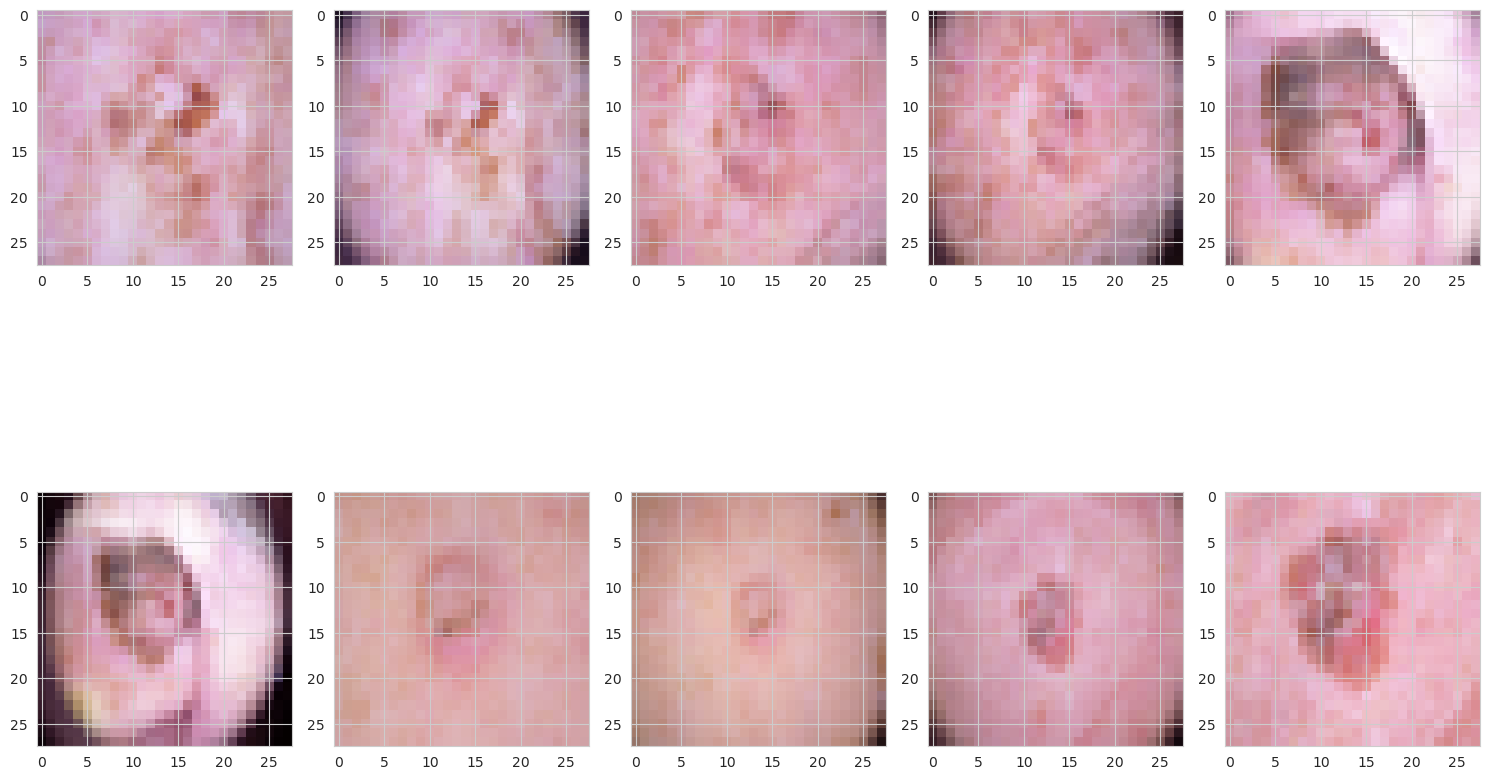

In [39]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
y1 = data['label']
x1 = data.drop(columns = ['label'])
x1= np.array(x1).reshape(-1,28,28,3)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x1[k].reshape(28,28,3))
#         ax[i, j].set_title(f"Image {Y_train[4]}")
        k = k + 1
    plt.tight_layout()

## Data Preprocessing
## Data Cleaning

In [40]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [41]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [42]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [43]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

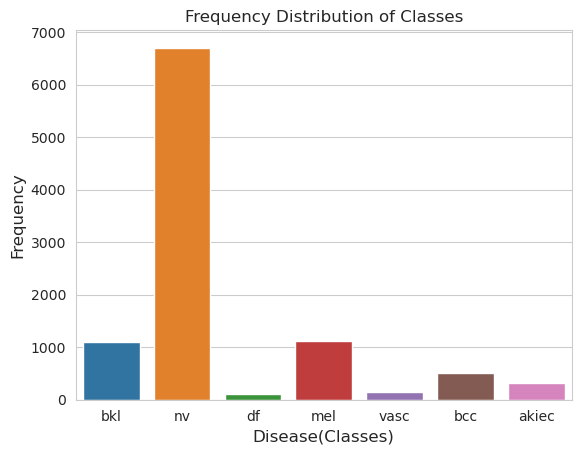

In [44]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

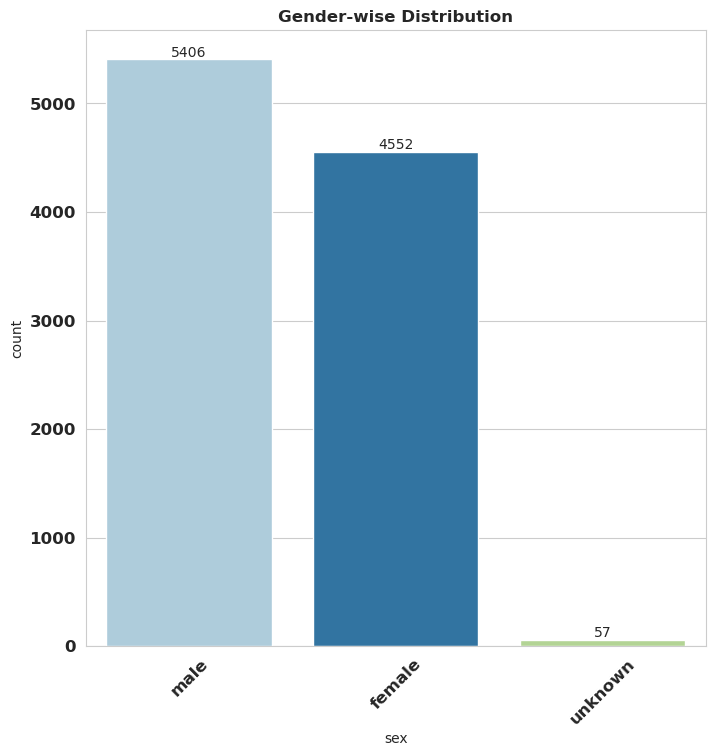

In [45]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution',fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.show()

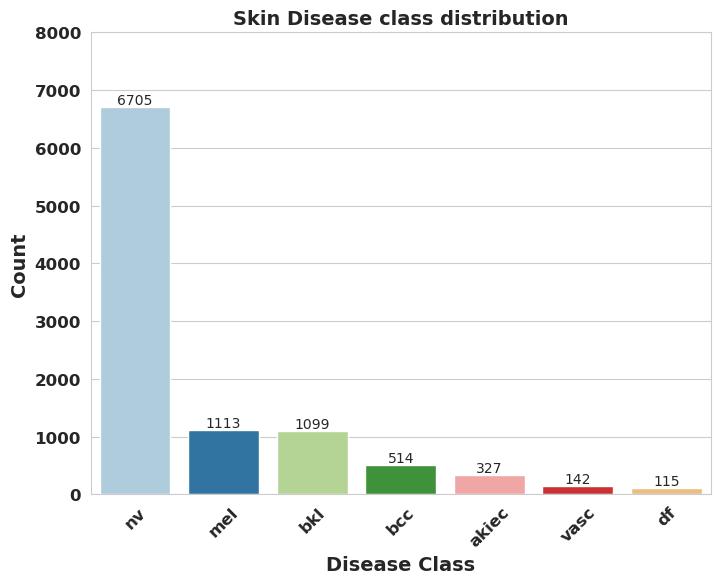

In [46]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Skin Disease class distribution',fontweight='bold',fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)
plt.show()

In [47]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


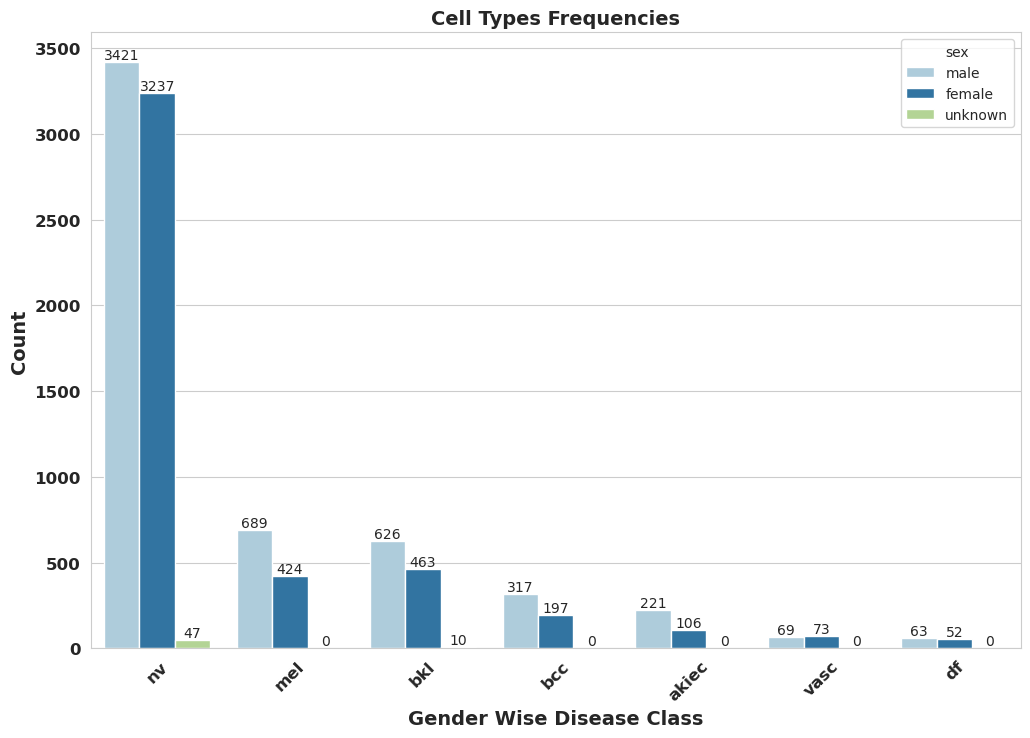

In [48]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Gender Wise Disease Class", fontweight='bold', fontsize=14)
plt.show()

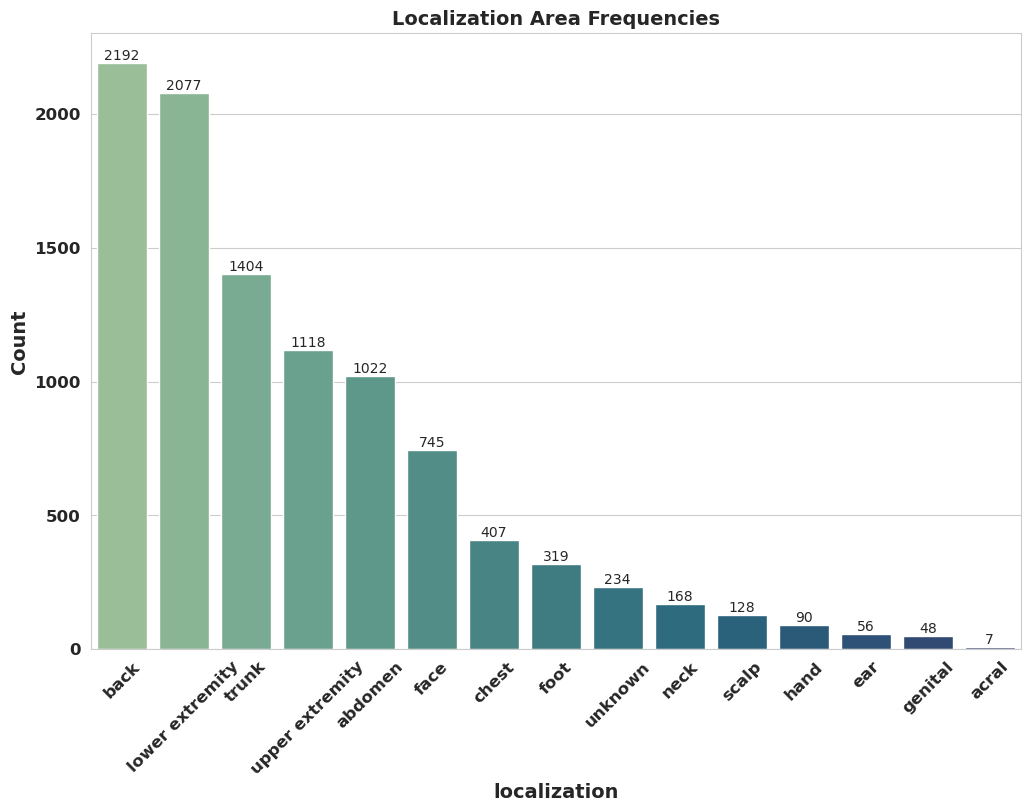

In [49]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies',fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("localization", fontweight='bold', fontsize=14)
plt.show()

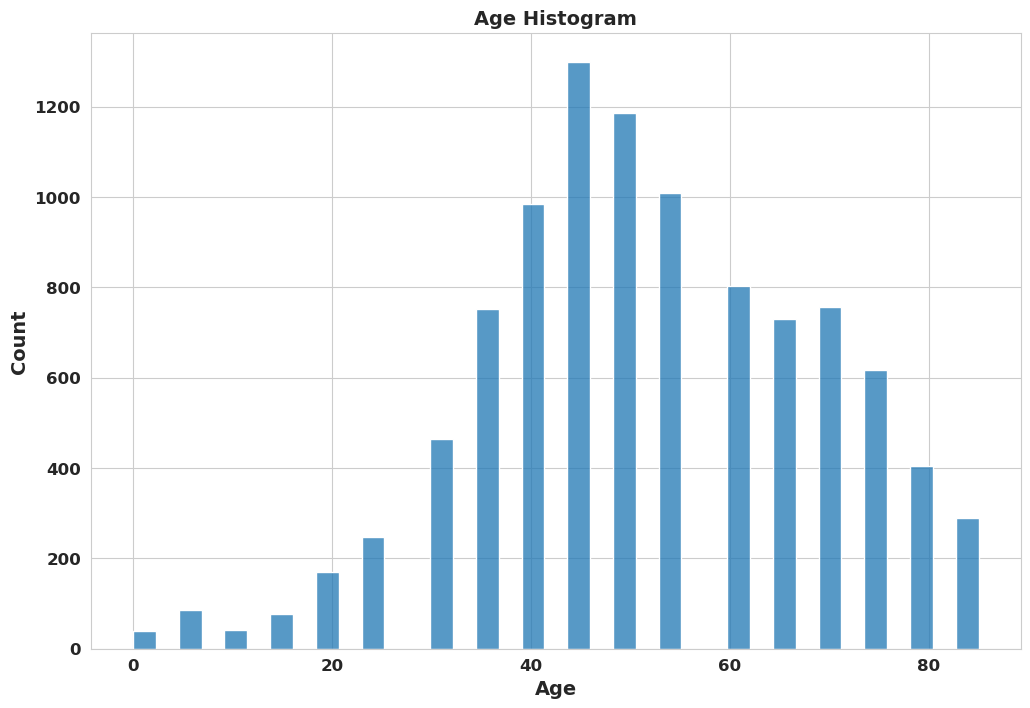

In [50]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

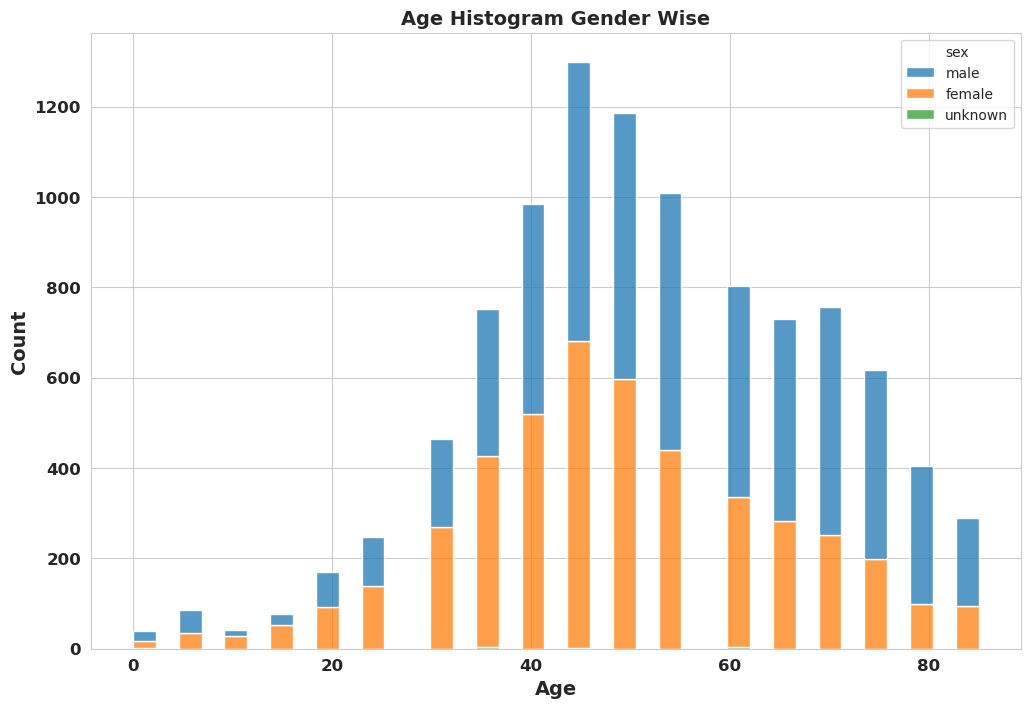

In [51]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise',fontweight='bold', fontsize=14)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Age", fontweight='bold', fontsize=14)
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create an ImageDataGenerator with desired augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
x= np.array(x).reshape(-1,28,28,3)

# Fit the ImageDataGenerator on the training data
datagen.fit(x)

# Generate augmented data
augmented_data = datagen.flow(x, y, batch_size=len(x), shuffle=False)

# Extract augmented samples and labels
augmented_samples, augmented_labels = next(augmented_data)

# Concatenate original and augmented data
balanced_x = np.concatenate((x, augmented_samples))
balanced_y = np.concatenate((y, augmented_labels))

print(balanced_x.shape, balanced_y.shape)

(20030, 28, 28, 3) (20030,)


In [79]:
# Splitting Data
print(balanced_x.shape,balanced_y.shape)
x1, X_test, y1, Y_test = train_test_split(balanced_x,balanced_y, test_size=0.2, random_state=1)
print(y1.shape,x1.shape)
print(X_test.shape , Y_test.shape)

(20030, 28, 28, 3) (20030,)
(16024,) (16024, 28, 28, 3)
(4006, 28, 28, 3) (4006,)


In [80]:
# reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
x1= np.array(x1).reshape(-1,28,28,3)
print('Shape of X :',x1.shape)
print('Shape of y :',y1.shape)

Shape of X : (16024, 28, 28, 3)
Shape of y : (16024,)


In [81]:
print(y1)

[6 6 4 ... 4 6 2]


In [82]:
newLabel = []

for i in range(len(y1)):
    for key in classes.keys():
        if y1[i] == key:
            newLabel.append(classes[key])



In [83]:
df = pd.DataFrame({'newLabel': newLabel})


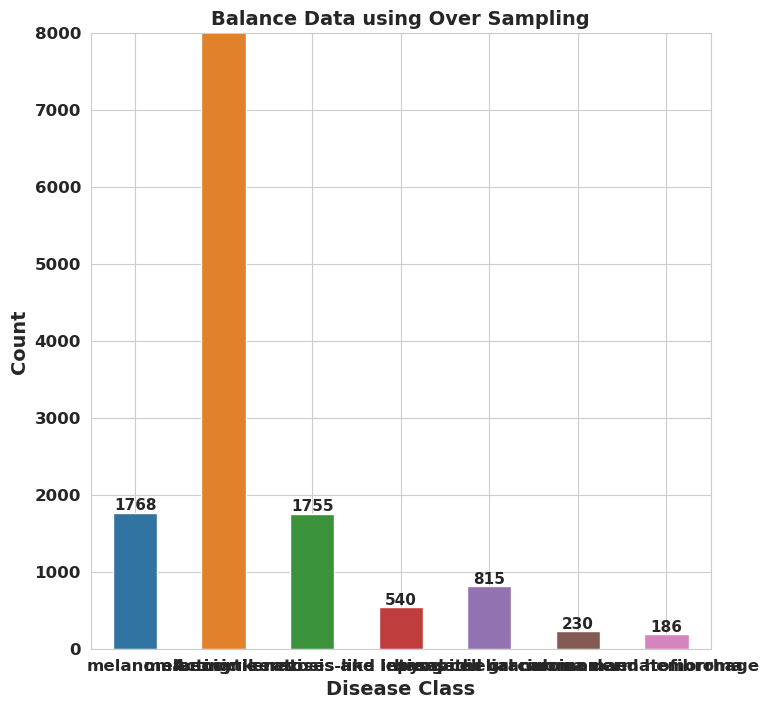

In [84]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,8))
ax = sns.countplot(x=newLabel,data=df,width=0.5)
for container in ax.containers:
    ax.bar_label(container, fontweight='bold', fontsize=11)
plt.title('Balance Data using Over Sampling', fontweight='bold', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)

plt.grid(linewidth=0.8)
plt.show()

In [85]:
x1 = np.array(x1).reshape(-1,28,28,3)
print('Shape of X :',x1.shape)
print('Shape of y :',y1.shape)

Shape of X : (16024, 28, 28, 3)
Shape of y : (16024,)


In [86]:
classes = {4:'melanocytic nevi',
6: 'melanoma',
2:'benign keratosis-like lesions',
1:'basal cell carcinoma',
5:'pyogenic granulomas and hemorrhage',
0:'Actinic keratoses and intraepithelial carcinomae',
3:'dermatofibroma'}


In [87]:
y1[:10]

array([6, 6, 4, 4, 2, 4, 4, 4, 4, 4])

In [88]:
l_train = np.array(y1)
l_train[1]

6

In [91]:
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())


model_CNN.add(MaxPool2D(pool_size = (2,2)))


model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model_CNN.add(Flatten())


model_CNN.add(Dense(64, activation = 'relu'))
model_CNN.add(BatchNormalization())


model_CNN.add(Dense(32))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(16))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(7))
model_CNN.add(Activation(activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_CNN.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
print(model_CNN.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_19 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                      

In [94]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
history = model_CNN.fit(x1,
                    y1,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 100,
                       callbacks=[reduce_lr,early_stop])

Epoch 1/100
201/201 [==============================] - 6s 9ms/step - loss: 1.3599 - accuracy: 0.5958 - val_loss: 0.9991 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 2/100
201/201 [==============================] - 2s 8ms/step - loss: 0.8689 - accuracy: 0.7254 - val_loss: 1.0536 - val_accuracy: 0.6618 - lr: 0.0010
Epoch 3/100
201/201 [==============================] - 2s 8ms/step - loss: 0.7323 - accuracy: 0.7428 - val_loss: 0.8644 - val_accuracy: 0.7101 - lr: 0.0010
Epoch 4/100
201/201 [==============================] - 2s 8ms/step - loss: 0.6700 - accuracy: 0.7602 - val_loss: 0.8010 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 5/100
201/201 [==============================] - 2s 9ms/step - loss: 0.6268 - accuracy: 0.7728 - val_loss: 0.7870 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 6/100
201/201 [==============================] - 2s 8ms/step - loss: 0.6010 - accuracy: 0.7817 - val_loss: 0.7591 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 7/100
201/201 [==============================] - 2s 8ms/st

In [95]:
X_test = np.array(X_test).reshape(-1,28,28,3)


In [96]:
results = model_CNN.evaluate(X_test , Y_test, verbose=0)

print("CNN Model Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN Model Test Results
        Test Loss: 0.63477
    Test Accuracy: 78.66%


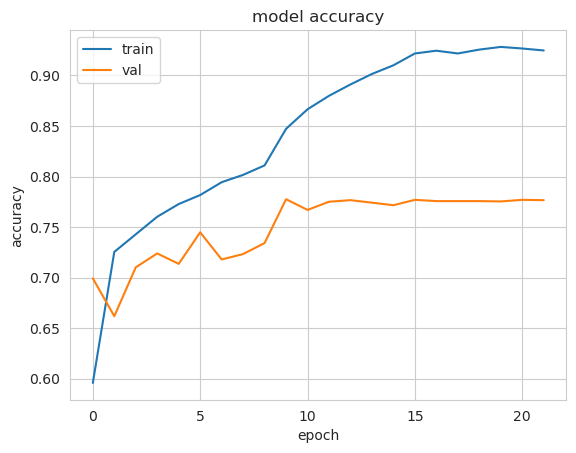

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

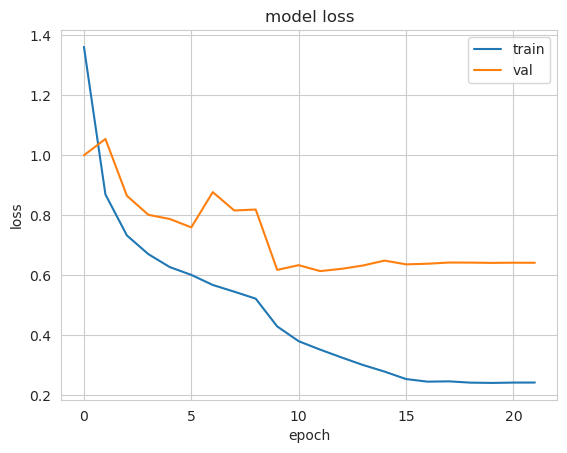

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(Y_test)
y_pred_CNN = model_CNN.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

126/126 [==============================] - 0s 2ms/step
Predicting First Ten Rows:
Y Actual Values : [1, 6, 6, 4, 6, 4, 4, 4, 4, 4]
Y Predicted Values : [1, 4, 2, 4, 6, 2, 4, 4, 4, 4]


[[ 235  141    0   29    0   24   14]
 [  67 2487    2  102    3   15    4]
 [   2   12    4    2    0   21    3]
 [  43  199    0  203    2    6    5]
 [   1    6    0    4   41    2    0]
 [  28   34    5    6    0  123   17]
 [  15   16    0    8    0   17   58]]


<Axes: >

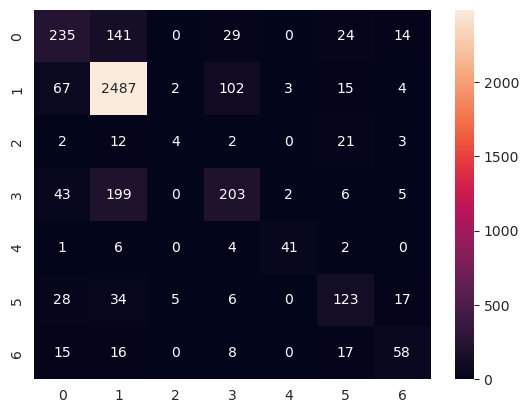

In [100]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

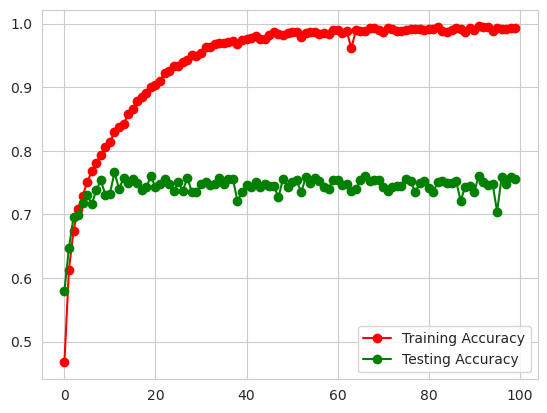

In [72]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [73]:
#predicting
y_pred_CNN  = model_CNN.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(Y_test , y_pred_CNN,target_names=target_names))

126/126 [==============================] - 0s 2ms/step
CNN Model Prediction Results
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       0.47      0.37      0.41       114
                            basal cell carcinoma       0.60      0.46      0.52       213
                   benign keratosis-like lesions       0.52      0.50      0.51       443
                                  dermatofibroma       0.22      0.32      0.26        44
                                melanocytic nevi       0.86      0.90      0.88      2680
              pyogenic granulomas and hemorrhage       0.71      0.50      0.59        54
                                        melanoma       0.46      0.43      0.44       458

                                        accuracy                           0.75      4006
                                       macro avg       0.55      0.50      0.52      4006
              

In [74]:
# Layers definitions
from keras import backend as K
for l in range(len(model_CNN.layers)):
    print(l, model_CNN.layers[l])

0 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f89a3803820>
1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f89a5501750>
2 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f898f9c7040>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f89a39c8070>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f898e2a8b20>
5 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f898f90ce20>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f898f9d7be0>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f898fbc7790>
8 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f898fbc7730>
9 <keras.layers.reshaping.flatten.Flatten object at 0x7f898fd890f0>
10 <keras.layers.core.dense.Dense object at 0x7f898fd8ada0>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f89a33ea8f0>
12 <keras.layers.core.dense.Dense object at 0x7f89

In [75]:
model_CNN.layers[-2]

In [76]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


## Separating Features Layers from the CNN Model

In [77]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.layers[-3].output)


## Extracting Features from CNN Model

In [78]:
# Extract features from input data using the CNN model
X_train_cnn = cnn_model_features.predict(X_train)
X_test_cnn = cnn_model_features.predict(X_test)

NameError: name 'X_train' is not defined

## Integrating CNN with SVM Classifier using Grid Search for Best Perameters

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf=SVC(kernel='rbf',C=100,gamma=0.001)
kf=KFold(n_splits=5)
scores_SVM = cross_val_score(clf, X_train_cnn, Y_train, cv=kf)
print(scores_SVM)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_SVM.mean(), scores_SVM.std()))
clf.fit(X_train_cnn, Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

In [ ]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testSVM,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))

## Integrating CNN with Random Forest Classifier using Grid Search for Best Perameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rgclf = RandomForestClassifier(max_depth=3,
               max_features=1,
               min_samples_split=3,
               bootstrap=False,
               criterion=  "entropy",
               n_estimators=20)
kf=KFold(n_splits=5)
scores_RF = cross_val_score(rgclf, X_train_cnn, Y_train, cv=kf)
print(scores_RF)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_RF.mean(), scores_RF.std()))
rgclf.fit(X_train_cnn, Y_train)
RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

In [ ]:
y_test_RF = rgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_test_RF,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

In [ ]:
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# parameters = {"n_neighbors": [1],
#               "weights": ['uniform', 'distance'],
#               "metric": ['minkowski','euclidean','manhattan'],
#               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kgclf = KNeighborsClassifier(n_neighbors=1,
              weights='distance',
              metric='euclidean',
              algorithm= 'auto')
kf=KFold(n_splits=5)
scores_KNN = cross_val_score(kgclf, X_train_cnn, Y_train, cv=kf)
print(scores_KNN)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_KNN.mean(), scores_KNN.std()))
kgclf.fit(X_train_cnn, Y_train)
KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)



In [ ]:
y_testKNN = kgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testKNN,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_testKNN)*100))

## Integrating CNN with Logistic Regression Classifier using Grid Search for Best Perameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Create a logistic regression object
grid_search_LR = LogisticRegression(C=100,
              penalty='l2')
kf=KFold(n_splits=5)
scores_LR = cross_val_score(grid_search_LR, X_train_cnn, Y_train, cv=kf)
print(scores_LR)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_LR.mean(), scores_LR.std()))
# Perform grid search with 5-fold cross-validation
grid_search_LR.fit(X_train_cnn, Y_train)

# Print the best hyperparameters and the corresponding accuracy score
y_test_LR = grid_search_LR.predict(X_test_cnn)

print(classification_report(Y_test, y_test_LR,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_LR)*100))

In [ ]:
X_test.head()